# Linear Discriminant Analysis (LDA)

> In this post, We will implement the basis of Linear Discriminant Analysis (LDA).

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Machine_Learning]
- image: images/lda.png

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

C:\Users\kcsgo\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kcsgo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\kcsgo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


## Linear Discriminant Analysis from scratch

### Dataset

Assume we have two multivariate normal distribution. That is, each distribution has 0 mean. And each distribution has 5000 samples.

In [2]:
mu0 = [0, 0]
sigma0 = np.array([[1, 0.5], [0.5, 1]])
sigma1 = np.array([[1, 0.5], [0.5, 1]])

X = np.random.multivariate_normal(mu0, sigma0, 5000)
X[2000:, 0] = X[2000:, 0] + 2
X[2000:, 1] = X[2000:, 1] + 2

y = np.ones((5000,))
y[:2000] = 0

In [3]:
X[:6, :], y[:6]

(array([[-0.61251247,  0.35804904],
        [ 0.29119936,  0.91157613],
        [-0.57915653,  1.444451  ],
        [ 0.4935298 , -1.27314726],
        [-0.16780727,  1.23802863],
        [ 0.00552064,  1.30737583]]),
 array([0., 0., 0., 0., 0., 0.]))

### Visualization

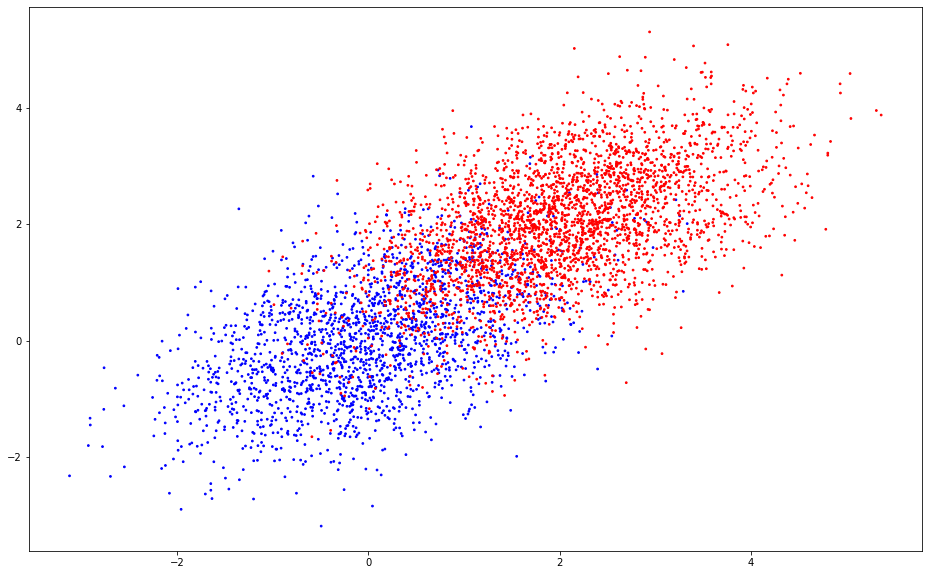

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
plt.scatter(X[:, 0], X[:, 1], s=3, c=list(map(lambda x:'blue' if x==0 else 'red', y)))
plt.show()

### Formula

To implement the LDA, we need to know the bayes rule. And it requires to implement probability distribution function. Basic notation is like this:

$$ f(x \vert y) = \frac{1}{\vert 2 \pi \Sigma \vert^{\frac{1}{2}}} \text{exp} \big( -\frac{1}{2} (x - \mu)^T (\Sigma)^{-1} (x - \mu)\big) $$

In case of binary classification (like above case), we can express the two kind of conditional probability cases that $y=0$ and $y=1$.

$$ f(x \vert y=0) = \frac{1}{\vert 2 \pi \Sigma^{(0)} \vert^{\frac{1}{2}}} \text{exp} \big( -\frac{1}{2} (x - \mu^{(0)})^T (\Sigma^{(0)})^{-1} (x - \mu^{(0)})\big)\\
f(x \vert y=1) = \frac{1}{\vert 2 \pi \Sigma^{(1)} \vert^{\frac{1}{2}}} \text{exp} \big( -\frac{1}{2} (x - \mu^{(1)})^T (\Sigma^{(1)})^{-1} (x - \mu^{(1)})\big) $$

In python, we can implement with numpy math operation.

In [5]:
mu0 = np.array([[0], [0]])
mu1 = np.array([[2], [2]])

def f_x_y_0(x):
    const = 1 / (2 * np.pi * np.power(np.linalg.det(sigma0), 1/2))
    return const * np.exp(-0.5 * (x - mu0).T @ np.linalg.inv(sigma0) @ (x - mu0))[0, 0]

def f_x_y_1(x):
    const = 1 / (2 * np.pi * np.power(np.linalg.det(sigma1), 1/2))
    return const * np.exp(-0.5 * (x - mu1).T @ np.linalg.inv(sigma1) @ (x - mu1))[0, 0]

In [6]:
f_x_y_0(np.array([[0.5], [0.5]]))

0.1555632781262252

In [7]:
f_x_y_1(np.array([[0.5], [0.5]]))

0.041006034909973794

Afterthat, we can define sample mean and covariance.

In [8]:
mu0_hat = np.mean(X[:2000, :], axis=0)
sigma0_hat = np.cov(X[:2000, :].T)
mu0_hat, sigma0_hat

(array([0.00559574, 0.03602649]),
 array([[0.97880838, 0.50920222],
        [0.50920222, 1.02418122]]))

In [9]:
mu1_hat = np.mean(X[2000:, :], axis=0)
sigma1_hat = np.cov(X[2000:, :].T)
mu1_hat, sigma1_hat

(array([1.99854606, 2.02145312]),
 array([[1.0468166 , 0.52618678],
        [0.52618678, 0.99421228]]))

Based on these, we can define the PDF of these distributions.

In [10]:
def fhat_x_y_0(x):
    const = 1 / (2 * np.pi * np.power(np.linalg.det(sigma0_hat), 1/2))
    return const * np.exp(-0.5 * (x - mu0_hat).T @ np.linalg.inv(sigma0_hat) @ (x - mu0_hat))[0, 0]

def fhat_x_y_1(x):
    const = 1 / (2 * np.pi * np.power(np.linalg.det(sigma1_hat), 1/2))
    return const * np.exp(-0.5 * (x - mu1_hat).T @ np.linalg.inv(sigma1_hat) @ (x - mu1_hat))[0, 0]

In [11]:
fhat_x_y_0(np.array([[0.5], [0.5]]))

0.157018648251265

In [12]:
fhat_x_y_1(np.array([[0.5], [0.5]]))

0.042578180185158014

Actually, we already know the distribution of label. Using this, we can calculate the bayes probability. The formula of bayes rule is like this:

$$ P(Y = y \vert X = x) = \frac{f(x \vert Y = y)P(Y = y)}{f(x \vert y = 0) P(Y = 0) + f(x \vert y=1)P(Y=1)} $$

In [13]:
p0 = 2000/5000
p1 = 1 - p0

def bayes_prob(x, y):
    if y == 1:
        return f_x_y_1(x) * p1 / (f_x_y_0(x) * p0 + f_x_y_1(x) * p1)
    else:
        return f_x_y_0(x) * p0 / (f_x_y_0(x) * p0 + f_x_y_1(x) * p1)

In [14]:
bayes_prob(np.array([[0.5], [0.5]]), 0)

0.7166425945408171

In [15]:
bayes_prob(np.array([[0.5], [0.5]]), 1)

0.2833574054591828

Also, we can estimate it with our hypothesis.

In [17]:
p0_hat = 2000 / 5000
p1_hat = 3000 / 5000
    
def bayes_prob_hat(x, y):
    if y == 1:
        return fhat_x_y_1(x) * p1_hat / (fhat_x_y_0(x) * p0_hat + fhat_x_y_1(x) * p1_hat)
    else:
        return fhat_x_y_0(x) * p0_hat / (fhat_x_y_0(x) * p0_hat + fhat_x_y_1(x) * p1_hat)

bayes_prob_hat(np.array([[0.5], [0.5]]), 0), bayes_prob_hat(np.array([[0.5], [0.5]]), 1)

(0.710858570328686, 0.2891414296713139)

We can confirm that sample data (`[0.5], [0.5]`) is classified with label `0`.

We can do the same process with Scikit-learn.

In [18]:
lda = LinearDiscriminantAnalysis(n_components=1, solver='svd', store_covariance=True).fit(X, y)

In [19]:
lda.means_

array([[0.00559574, 0.03602649],
       [1.99854606, 2.02145312]])

In [20]:
mu0 = lda.means_[0, :]
mu1 = lda.means_[1, :]
lda_cov = lda.covariance_

mu0, mu1, lda_cov

(array([0.00559574, 0.03602649]),
 array([1.99854606, 2.02145312]),
 array([[1.01920819, 0.51918588],
        [0.51918588, 1.00579618]]))

Using trained discriminator, we can calculate the probability of each label. For doing this, we need to implement delta function to express it.
The formula of delta function is like this.

$$ \delta_k(x) = x^T \Sigma^{-1} \mu_k - \frac{1}{2} \mu^T_k \Sigma^{-1} \mu_k + \log \pi_k $$

All we need to do is apply argmax operation in that probability.

In [25]:
def discriminator(x):
    d0 = x.T @ np.linalg.inv(lda_cov) @ mu0 - 0.5 * mu0.T @ np.linalg.inv(lda_cov) @ mu0 + np.log(p0)
    d1 = x.T @ np.linalg.inv(lda_cov) @ mu1 - 0.5 * mu1.T @ np.linalg.inv(lda_cov) @ mu1 + np.log(p1)
    return [d0[0], d1[0]]

In [26]:
discriminator(np.array([[0.5], [0.5]]))

[-0.903325550804457, -1.8368770569319148]

In [27]:
np.argmax(discriminator(np.array([[0.5], [0.5]])))

0

Through this, we can confirm that LDA model can classify the sample data (`[0.5], [0.5]`) with 0.

So how about the accuracy of fitted LDA model?

In [29]:
y_hat = np.apply_along_axis(lambda x: np.argmax(discriminator(np.reshape(x, (2, 1)))), 1, X)

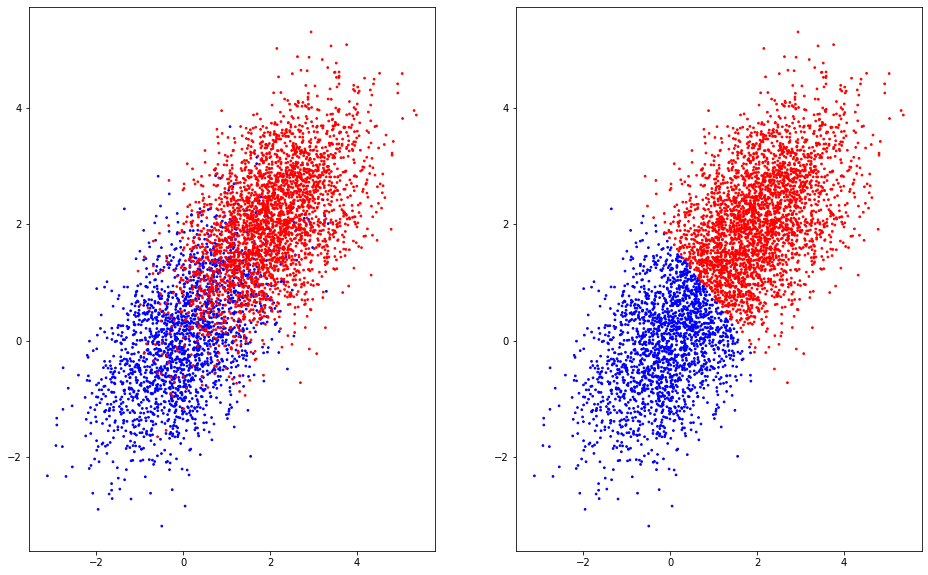

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].scatter(X[:, 0], X[:, 1], s=3, c=list(map(lambda x:'blue' if x==0 else 'red', y)))
ax[1].scatter(X[:, 0], X[:, 1], s=3, c=list(map(lambda x:'blue' if x==0 else 'red', y_hat)))
plt.show()

In [32]:
(y == y_hat).mean()

0.8726

LDA is one of Linear Classifier. So we can the result of LDA classification, though some errors are occurred. As a result, LDA classifier has almost 87% accuracy of random dataset.